In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances

import warnings; warnings.simplefilter('ignore')

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

userId     100836
movieId    100836
rating     100836
dtype: int64

In [3]:
df = pd.merge(ratings, movies, on='movieId')

In [4]:
# Break up the big genre string into a string array
df['genres'] = df['genres'].str.split('|')
# Convert genres to string value
df['genres'] = df['genres'].fillna("").astype('str')

In [5]:
df

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,5,1,4.0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
2,7,1,4.5,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
3,15,1,2.5,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
4,17,1,4.5,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
5,18,1,3.5,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
6,19,1,4.0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
7,21,1,3.5,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
8,27,1,3.0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
9,31,1,5.0,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."


In [6]:
df.shape

(100836, 5)

DATA EXPLORATION

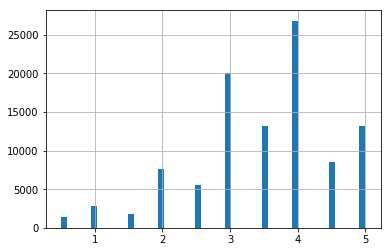

In [7]:
df['rating'].hist(bins=50)

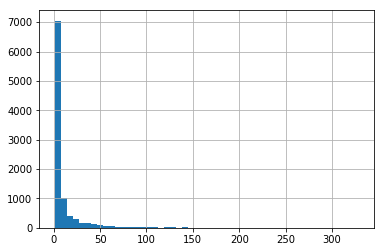

In [8]:
number_of_ratings = df.groupby('title')['rating'].count()
number_of_ratings.hist(bins=50)

In [9]:
average_rating = df.groupby('title')['rating'].mean().sort_values(ascending=False).head()
average_rating

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [10]:
vote_count = df.groupby('title')['rating'].count().sort_values(ascending=False).head()
vote_count

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [11]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())  
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [12]:
ratings['count'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.sort_values('count',ascending=False).head()

,rating,count
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


### SIMPLE RECOMMENDER:
MOVIE RECOMMENDATIONS BASED ON SIMILAR MOVIE GENRES

In [13]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [14]:
#pairwise cosine similarity matrix for all the movies in the dataset
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.31379419, 0.0611029 , ..., 0.        , 0.16123168,
        0.16761358],
       [0.31379419, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0611029 , 0.        , 1.        , ..., 0.        , 0.        ,
        0.36454626],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.16123168, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.16761358, 0.        , 0.36454626, ..., 0.        , 0.        ,
        1.        ]])

In [15]:
print(tfidf_matrix.shape)
print(cosine_sim.shape)

(9742, 177)
(9742, 9742)


In [16]:
sim = pd.DataFrame(cosine_sim)

In [17]:
#Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based similarity of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices].head(10)

In [18]:
genre_recommendations('Toy Story (1995)')

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

SAME USING CORRWITH

In [19]:
movie_matrix = df.pivot_table(index='genres', columns='title', values='rating') 
movie_matrix.fillna(0,inplace=True)

In [20]:
def general_recommend(movie):
    similar_movies = movie_matrix.corrwith(movie_matrix[movie]) 
    corr_movies = pd.DataFrame(similar_movies, columns=['similarity'])
    corr_movies.dropna(inplace=True)
    recommended = corr_movies.sort_values('similarity', ascending=False).join(ratings['count'])
    return recommended.head(10)       

In [ ]:
#movie = input('Enter a movie name: ')

In [21]:
general_recommend('Toy Story (1995)')

,similarity,count
title,,
Moana (2016),1.0,10
"Monsters, Inc. (2001)",1.0,132
"Adventures of Rocky and Bullwinkle, The (2000)",1.0,9
Antz (1998),1.0,45
Toy Story (1995),1.0,215
"Tale of Despereaux, The (2008)",1.0,1
The Good Dinosaur (2015),1.0,4
Toy Story 2 (1999),1.0,97
Shrek the Third (2007),1.0,21


### CONTENT BASED RECOMMENDATION
Recommend movies that are close to movies loved by the particular user only.

In [23]:
def recommend(user):
    #create a user profile
    u = df[df['userId']== user]
    user_profile = u[['title','rating','genres']]
    loved = (user_profile[user_profile['rating'].between(4,5)]).iloc[:20]
    hated = user_profile[user_profile['rating'].between(1,3)]
    
    #look for similar movies that user has liked
    search_movies = movie_matrix.corrwith(movie_matrix[list(loved['title'])])    
    corr_movies = pd.DataFrame(search_movies, columns=['similarity'])
    corr_movies.dropna(inplace=True)
    recommends = corr_movies.head(10)
    
    #check if recommended movies are in user's hated movie list
    return recommends    

In [55]:
user = int(input('Enter your user_id: '))

Enter your user_id: 1


In [56]:
recommend(user)

,similarity
title,
Billy Madison (1995),1.0
Bottle Rocket (1996),1.0
Braveheart (1995),1.0
Canadian Bacon (1995),1.0
Clear and Present Danger (1994),1.0
Dazed and Confused (1993),1.0
Desperado (1995),1.0
Dumb & Dumber (Dumb and Dumber) (1994),1.0
Ed Wood (1994),1.0


In [26]:
# not done: check if suggested movies are in user's hated movie list

### COLLABORATIVE FILTERING
Recommend movies based on similar users 

In [27]:
# create a user-item similarity matrix
user_movie_rating = df.pivot_table(index='userId', columns='title', values='rating') 
user_movie_rating.fillna(0, inplace=True)
user_movie_rating

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


I AM DOING THIS SPLIT FOR THE PURPOSE OF SHOWING THE EVALUVATION RESULTS OF MY PREDICTIONS.

In [28]:
trainset, testset = train_test_split(user_movie_rating)
trainset.shape, testset.shape

((457, 9719), (153, 9719))

In [29]:
svd = TruncatedSVD(n_components=5,n_iter=50,random_state=42)
x= svd.fit_transform(trainset)

In [30]:
print(svd.explained_variance_ratio_.sum()) 

0.23427061138940097


PREDICT OVER THE TEST DATA AND EVALUATE THE ERROR


In [31]:
test_pred = svd.transform(testset)

In [32]:
test_pred_filled = svd.inverse_transform(test_pred)

In [33]:
test_pred.shape, test_pred_filled.shape

((153, 5), (153, 9719))

In [34]:
test_actual = testset.values

In [35]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_actual,test_pred_filled)

0.1969317300463212

From above, we see that MAE is decent showing predictions acuuracy of 85%.

Next, lets find simialr users using the above measures

In [36]:
svd = TruncatedSVD(n_components=5,n_iter=50,random_state=42)
x = svd.fit_transform(user_movie_rating)

In [37]:
user_movie_pred = svd.inverse_transform(x)

In [38]:
dense_matrix = pd.DataFrame(user_movie_pred) 
dense_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718
0,0.035153,0.012526,0.019914,0.006163,0.006415,0.004065,0.468869,-0.060377,-0.304887,0.149515,...,0.026588,0.196817,0.109112,0.095503,-0.004105,0.548571,0.184854,0.008456,0.633080,0.007513
1,0.014135,0.006655,0.005067,-0.000870,-0.001719,0.002184,-0.050658,-0.010674,0.171963,-0.012084,...,-0.001939,0.034718,0.017524,0.010534,0.002279,-0.017885,0.038283,0.015930,-0.052568,-0.000901
2,0.004516,-0.000269,0.000298,0.000341,-0.000045,0.000427,0.028032,-0.005878,-0.024115,0.009455,...,0.002469,0.015551,0.009901,0.009558,-0.000057,0.024632,0.012749,0.001312,0.032704,0.000411
3,-0.024387,0.015499,0.018487,0.005705,0.017788,-0.010055,0.187226,0.093053,-0.070346,0.050406,...,-0.006373,-0.087997,-0.051095,-0.052334,-0.004972,0.515206,-0.058065,-0.037774,0.325024,0.002052
4,-0.045753,0.001636,0.000126,-0.001078,0.001200,-0.001098,-0.020961,0.010646,-0.060638,-0.014601,...,-0.009147,-0.063401,-0.053902,-0.052529,-0.003562,-0.071820,-0.039828,-0.014276,0.005849,0.000755


In [39]:
#User-user similarity 
user_similarity = 1 - pairwise_distances(dense_matrix, metric="cosine")
np.fill_diagonal(user_similarity, 0) 
user_similarity_matrix = pd.DataFrame(user_similarity)
user_similarity_matrix.shape


(610, 610)

In [40]:
#Item-item similarity - I will not be using this
movie_similarity = 1 - pairwise_distances(dense_matrix.T, metric="cosine") #user_movie_rating
np.fill_diagonal(movie_similarity, 0) 
movie_similarity_matrix = pd.DataFrame(movie_similarity)
movie_similarity_matrix.shape

(9719, 9719)

In [41]:
from sklearn.neighbors import NearestNeighbors

def get_sim_users(user_id, ratings,metric,k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric=metric,algorithm='auto') 
    model_knn.fit(ratings)
    distances, indices = model_knn.kneighbors(ratings.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print('{0} most similar users for User {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue
        else:
            print('{0}: User {1}, with similarity of {2}'.format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
            
    return similarities

In [42]:
similarities = get_sim_users(1,user_similarity_matrix,'cosine',5)

5 most similar users for User 1:

1: User 546, with similarity of 0.995763116229259
2: User 135, with similarity of 0.9951652317347829
3: User 452, with similarity of 0.9939844270902146
4: User 91, with similarity of 0.9931169887049989
5: User 186, with similarity of 0.9925291009090143


SURPRISE PACKAGE: SVD does all the job of prediction and evaluation in one shot

In [43]:
from surprise import accuracy
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD,evaluate

In [44]:
reader = Reader(rating_scale=(1, 5))

In [45]:
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [46]:
data.split(n_folds=5)
svd = SVD(n_factors=500, n_epochs=10)
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8883
MAE:  0.6868
------------
Fold 2
RMSE: 0.8932
MAE:  0.6888
------------
Fold 3
RMSE: 0.9032
MAE:  0.6964
------------
Fold 4
RMSE: 0.9024
MAE:  0.6942
------------
Fold 5
RMSE: 0.9011
MAE:  0.6982
------------
------------
Mean RMSE: 0.8976
Mean MAE : 0.6929
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.888309236185717,
                             0.8931667631592505,
                             0.9032456214224434,
                             0.9023985837273754,
                             0.9010972622730666],
                            'mae': [0.6867517957586831,
                             0.6888415000127662,
                             0.6964228035877913,
                             0.6942062239551882,
                             0.6981821600937086]})

In [47]:
data = data.build_full_trainset()
svd.train(data)

In [48]:
pred = svd.predict(610, 1)
pred

Prediction(uid=610, iid=1, r_ui=None, est=4.435778449148769, details={'was_impossible': False})

In [50]:
pred.est

4.435778449148769

In [51]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings[ratings['userId'] == 610].head()

,userId,movieId,rating
99534,610,1,5.0
99535,610,6,5.0
99536,610,16,4.5
99537,610,32,4.5
99538,610,47,5.0


In [52]:
def get_preds(user):
    u = ratings[ratings['userId']==user]
    u_pred_profile = u[['userId', 'movieId','rating']]
    u_pred_profile['prediction'] = u_pred_profile['movieId'].apply(lambda x: svd.predict(user,x)[3])
    return u_pred_profile    

In [57]:
df_pred = get_preds(100)
df_pred.head()

,userId,movieId,rating,prediction
15300,100,3,3.5,3.637776
15301,100,11,4.0,3.896834
15302,100,16,4.5,4.202003
15303,100,17,4.5,4.337948
15304,100,19,1.0,2.388643


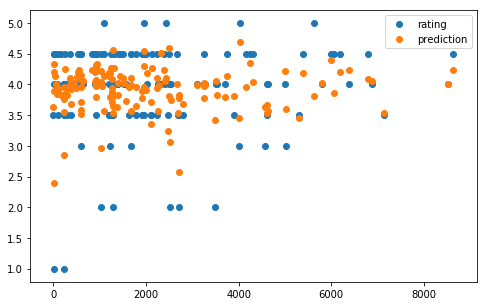

In [58]:
fig, ax = plt.subplots(figsize = (8,5)) 
ax.scatter(df_pred['movieId'],df_pred['rating'])
ax.scatter(df_pred['movieId'],df_pred['prediction'])
ax.legend()
